In [30]:
import numpy as np
import pandas as pd
from tscv import GapRollForward
from tqdm.notebook import tqdm
from sklearn.ensemble import HistGradientBoostingRegressor

region = 'sa'

# extract holidays from file
holiday_df = pd.read_csv('../data/holidays2017_2024.csv', dtype='str')
holiday_df['Date'] = holiday_df['Date'].astype('datetime64[ns]').dt.date
holidays = holiday_df.loc[holiday_df['Jurisdiction'] == region, ['Date', 'Holiday Name']]
holidict = {name: i+1 for i, name in enumerate(holidays['Holiday Name'].unique())}

# import and preprocess load and weather data
df = pd.read_csv(f'../data/{region}/merged.csv')
df['datetime'] = df['datetime'].astype('datetime64')
dt = df['datetime'].dt
df['year'] = dt.year
df['month'] = dt.month
df['day'] = dt.day
df['hour'] = dt.hour
df['minute'] = dt.minute
df['dow'] = dt.day_of_week
df['week'] = dt.isocalendar().week

# compute universal X and y column indices
X_EXCLUDE = ['datetime', 'net_load', 'total_load', 'pv_est']
X_cols = np.setdiff1d(df.columns.values, X_EXCLUDE)
y_ind = df.columns.get_loc('net_load')

# add holiday encodings
df['holiday_bin'] = dt.date.isin(holidays['Date']).astype('int')
merged = pd.merge(dt.date, holidays, left_on='datetime', right_on='Date', how='left')
df['holiday_cat'] = merged['Holiday Name'].replace(holidict).fillna(0).astype('int')
df['working_day'] = np.logical_not(np.logical_or(df['holiday_bin'], df['dow'] >= 5))

# for convenience below
obs = np.arange(10000) * 24

# create train/test window strategies
tscv_annual = GapRollForward(
    min_train_size = obs[365], 
    max_train_size = obs[365],
    min_test_size = obs[7], 
    max_test_size = obs[7],
    roll_size = obs[30])

tscv_semiannual = GapRollForward(
    min_train_size = obs[365//2], 
    max_train_size = obs[365//2],
    min_test_size = obs[7], 
    max_test_size = obs[7],
    roll_size = obs[30])

tscv_biannual = GapRollForward(
    min_train_size = obs[365*2], 
    max_train_size = obs[365*2],
    min_test_size = obs[7], 
    max_test_size = obs[7],
    roll_size = obs[30])

tscv_triannual = GapRollForward(
    min_train_size = obs[365*3], 
    max_train_size = obs[365*3],
    min_test_size = obs[7], 
    max_test_size = obs[7],
    roll_size = obs[30])

print(sum(1 for i in tscv_annual.split(df)), f' annual windows to be trained')
print(sum(1 for i in tscv_semiannual.split(df)), f' semiannual windows to be trained')
print(sum(1 for i in tscv_biannual.split(df)), f' biannual windows to be trained')
print(sum(1 for i in tscv_triannual.split(df)), f' triannual windows to be trained')

X_cols

49  annual windows to be trained
55  semiannual windows to be trained
37  biannual windows to be trained
25  triannual windows to be trained


array(['cloud8', 'day', 'dow', 'hour', 'humid', 'minute', 'month',
       'radkjm2', 'rainmm', 'tempc', 'wdir', 'week', 'windk', 'year'],
      dtype=object)

In [31]:
tscv = {'semiannual': tscv_semiannual,
        'annual': tscv_annual, 
        'biannual': tscv_biannual, 
        'triannual': tscv_triannual}

prdfs = []
# execute train/test window strategies
for strategy, cv in tscv.items():
    for i, (train_ind, test_ind) in tqdm(enumerate(cv.split(df))):
        for include in [[], ['holiday_bin'], ['holiday_cat'], ['working_day']]:
            X_inds = sorted(df.columns.get_indexer_for(X_cols.tolist() + include))

            X_train, X_test = df.iloc[train_ind, X_inds], df.iloc[test_ind, X_inds]
            y_train, y_test = df.iloc[train_ind, y_ind], df.iloc[test_ind, y_ind]

            # train model
            begin, end = df.iloc[[train_ind[0], train_ind[-1]], 0].dt.date
            model = HistGradientBoostingRegressor()
            model.fit(X_train, y_train)

            # predict
            prd = model.predict(X_test)
            prdf = pd.DataFrame({'datetime': df.iloc[test_ind, 0],
                                'model': i,
                                'encoding': include[0] if include else 'no_holiday',
                                'holiday': df.iloc[test_ind, :]['holiday_bin'],
                                'window': strategy,
                                'train_end': end,
                                'predicted': prd,
                                'net_load': y_test})
            prdfs.append(prdf)

# concatenate predictions and compute discrete error metrics
predictions = pd.concat(prdfs)
predictions['Residual'] = predictions['predicted'] - predictions['net_load']
predictions['Absolute Error'] = predictions['Residual'].abs()
predictions['Percent Error'] = predictions['Residual'] / predictions['net_load']
predictions['Absolute Percent Error'] = predictions['Percent Error'].abs()
predictions['Squared Error'] = predictions['Residual'] ** 2

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

week ahead performance metrics

In [32]:
metrics = predictions.groupby(['window', 'encoding']).mean(numeric_only = True).reset_index()

metrics['RMSE'] = np.sqrt(metrics['Squared Error']).round(2)
metrics['MAE'] = metrics['Absolute Error'].round(2)
metrics['MAPE'] = np.round(metrics['Absolute Percent Error'] * 100, 2)

metrics[['window', 'encoding', 'MAE', 'MAPE', 'RMSE']].sort_values(['RMSE'])

,window,encoding,MAE,MAPE,RMSE
5,biannual,holiday_cat,93.25,8.79,134.12
7,biannual,working_day,93.01,8.72,134.46
4,biannual,holiday_bin,93.57,8.83,135.38
13,triannual,holiday_cat,95.26,9.01,137.86
12,triannual,holiday_bin,95.02,8.95,137.94
15,triannual,working_day,95.12,8.97,138.18
6,biannual,no_holiday,95.77,8.98,138.66
14,triannual,no_holiday,95.93,9.16,138.71
0,annual,holiday_bin,98.71,9.20,140.98
3,annual,working_day,98.19,9.14,141.09


In [33]:
metrics = predictions.groupby(['window', 'encoding', 'holiday']).agg(
    RMSE = ('Squared Error', lambda x: np.sqrt(x.mean())),
    MAPE = ('Absolute Percent Error', lambda x: 100*np.mean(x)),
    MAE = ('Absolute Error', np.mean),
    count = ('datetime', 'count')
).reset_index().round(2)
#metrics['RMSE'] = np.sqrt(metrics['Squared Error']).round(2)

#metrics[['window', 'encoding', 'holiday', 'RMSE']].sort_values(['holiday', 'RMSE'])
metrics.pivot(index=['window', 'encoding'], columns=['holiday'], values=['MAE', 'MAPE', 'RMSE'])

MAE          MAPE           RMSE        
holiday                      0       1     0      1       0       1
window     encoding                                                
annual     holiday_bin   98.84   95.64  9.08  11.98  141.39  131.29
           holiday_cat   99.19   98.78  9.13  12.16  141.94  132.85
           no_holiday    97.94  146.64  8.97  17.67  140.43  192.45
           working_day   98.20   98.06  8.99  12.71  141.30  136.27
biannual   holiday_bin   93.66   92.53  8.67  10.81  136.19  125.18
           holiday_cat   93.18   94.11  8.63  10.72  134.79  125.67
           no_holiday    94.26  113.96  8.63  13.19  137.45  152.51
           working_day   93.57   86.20  8.62   9.96  135.91  115.61
semiannual holiday_bin  113.84  122.32  9.26  14.57  165.95  165.32
           holiday_cat  114.14  121.55  9.30  14.32  165.56  163.28
           no_holiday   113.49  175.84  9.26  20.78  164.19  227.48
           working_day  113.02  123.13  9.20  15.22  164.10  171.62
triannual  holiday_bin   92.20  139.50  8.65  13.61  133.12  199.15
           holiday_cat   92.72  135.30  8.71  13.71  133.85  190.35
           no_holiday    92.61  148.38  8.67  17.00  134.02  198.55
           working_day   92.68  133.66  8.73  12.75  133.73  195.53

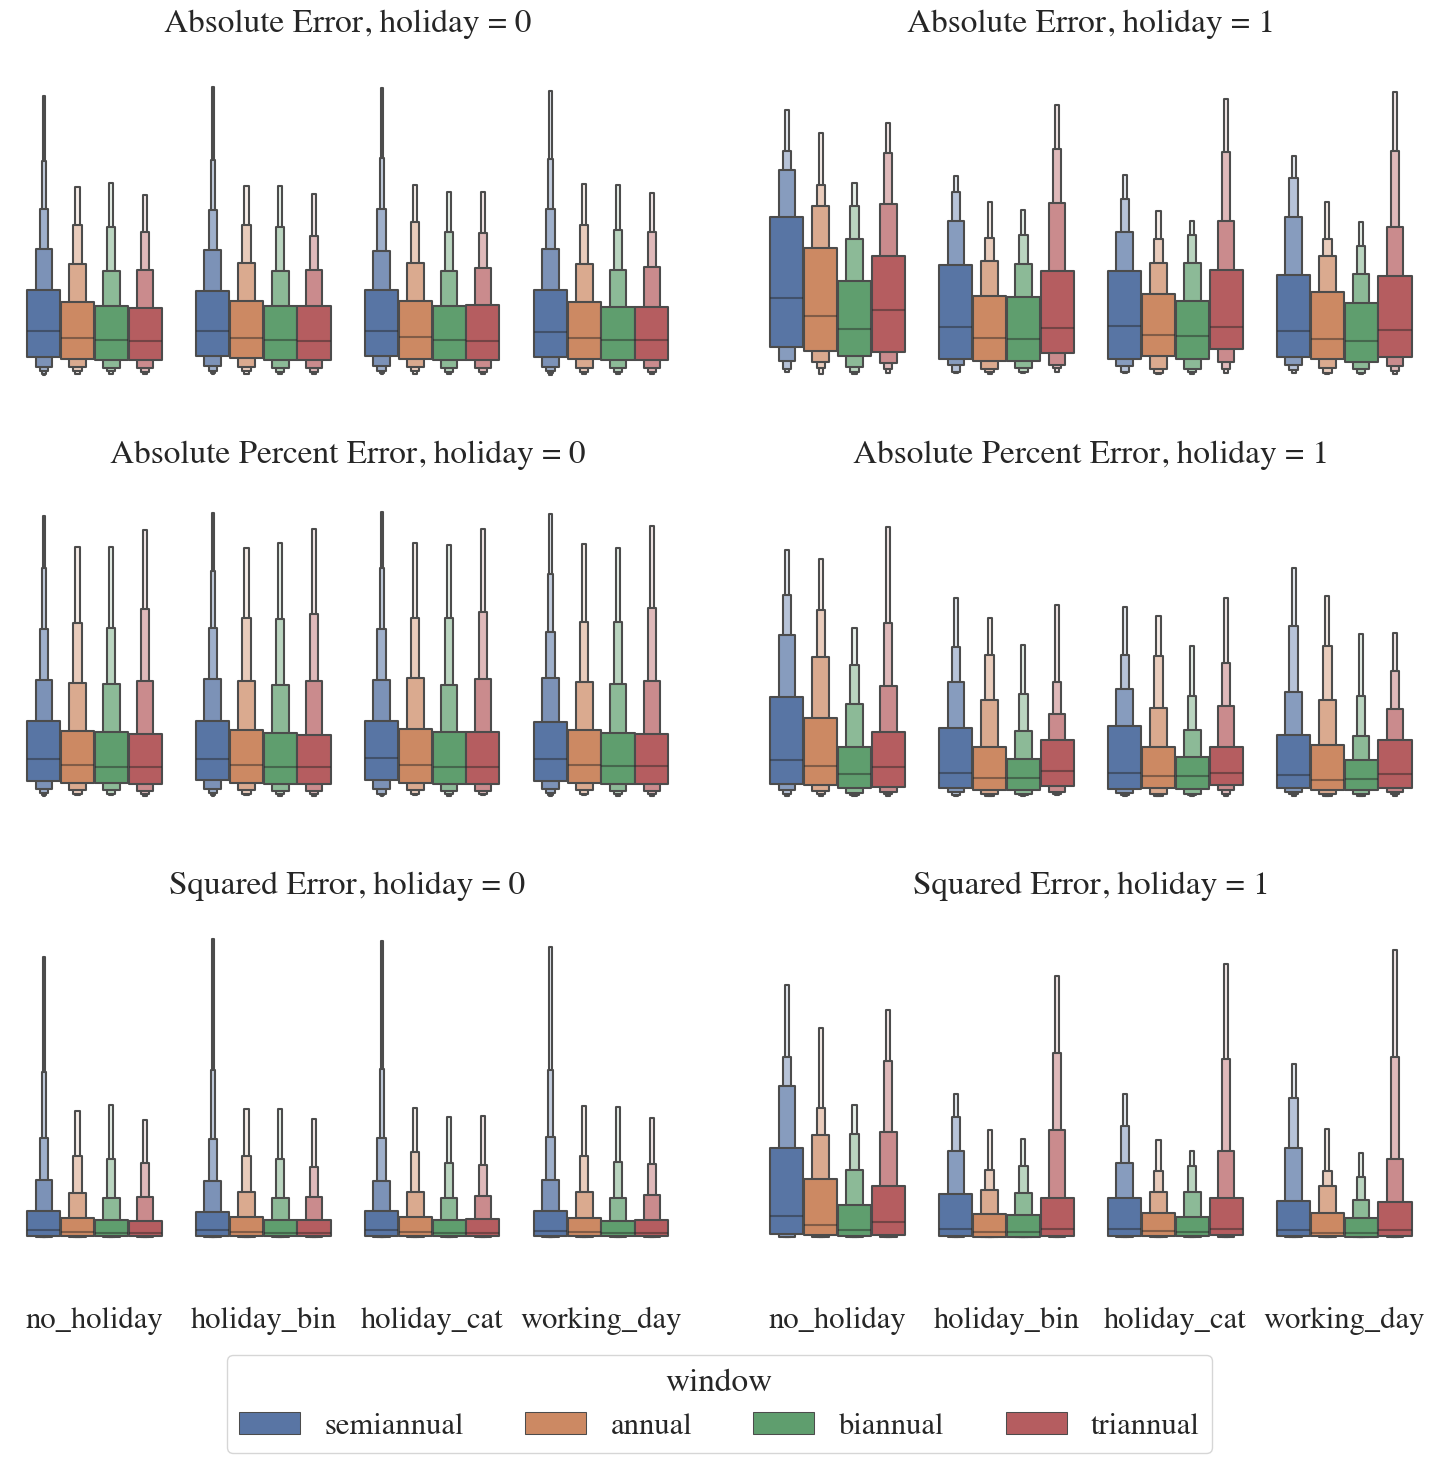

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(font_scale=2, font='times', style='white')

cat_df = predictions.melt(['datetime', 'window', 'encoding', 'holiday'], 
                          ['Absolute Error', 'Absolute Percent Error', 'Squared Error'])

g = sns.catplot(cat_df, kind='boxen', x='encoding', y='value', showfliers=False, legend_out=False,
                row='variable', col='holiday', hue='window', sharey=False, height=5, aspect=1.5,
                k_depth='proportion', outlier_prop=0.1)
g.set_titles('{row_name}, {col_var} = {col_name}')
g.set_ylabels('')
g.set_yticklabels('')
g.set_xlabels('')
# g.tick_params('x', rotation=20)
g.despine(bottom=True, left=True)
g.tight_layout()
sns.move_legend(g, 'lower center', ncol=4)
plt.subplots_adjust(hspace=0.1, wspace=0.1, bottom=0.12)
g.savefig('../plots/hgb_window_annual')

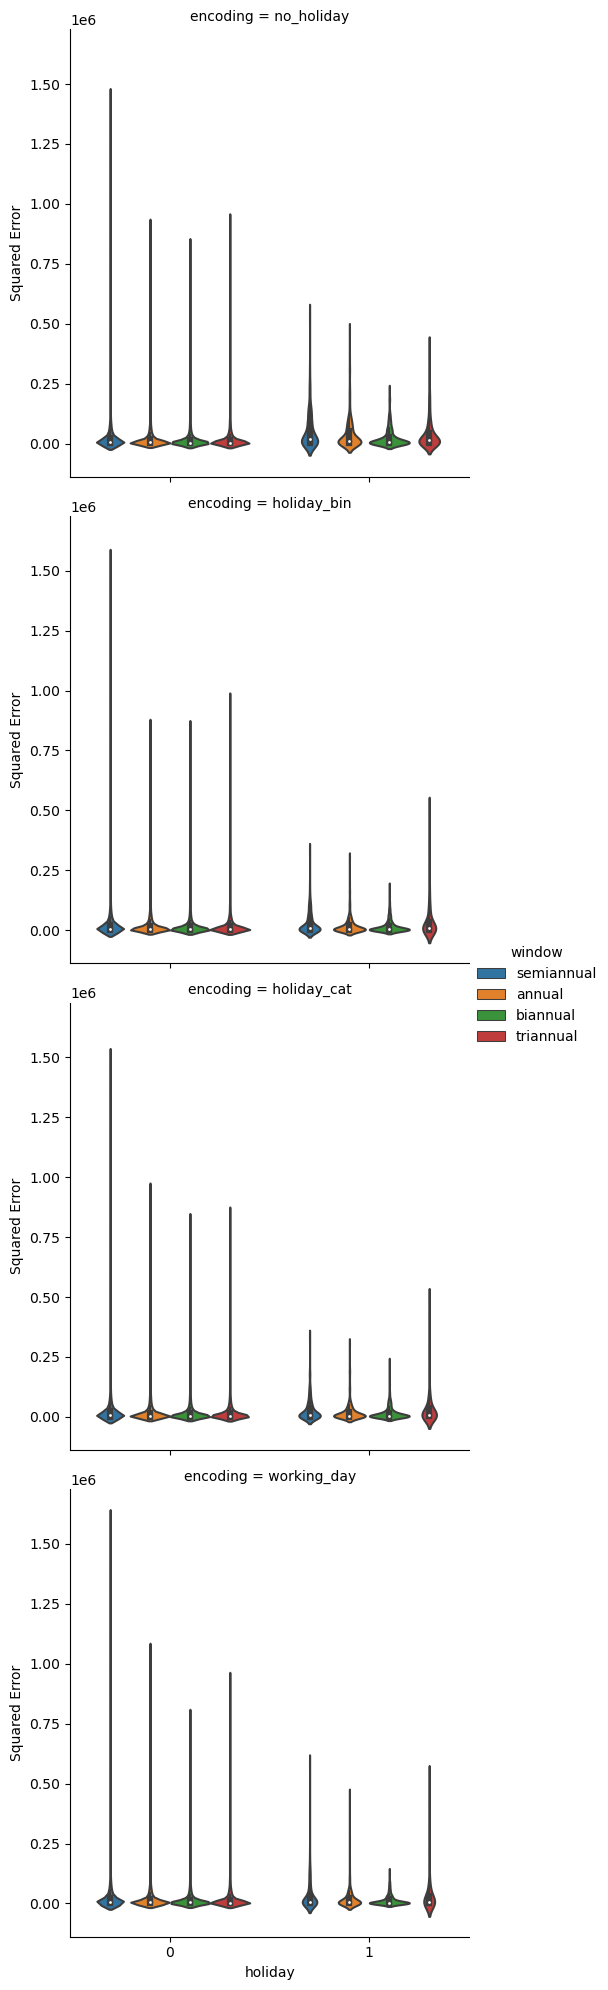

In [34]:
import seaborn as sns

sns.catplot(predictions, kind='violin', 
            y='Squared Error', row='encoding', x='holiday', hue='window')

In [35]:
vals = metrics.pivot(index=['window', 'encoding'], columns=['holiday'], values=['MAE', 'MAPE', 'RMSE']).values
for row in vals:
    print('\t&\t'.join([str(x) for x in row]))

98.84	&	95.64	&	9.08	&	11.98	&	141.39	&	131.29
99.19	&	98.78	&	9.13	&	12.16	&	141.94	&	132.85
97.94	&	146.64	&	8.97	&	17.67	&	140.43	&	192.45
98.2	&	98.06	&	8.99	&	12.71	&	141.3	&	136.27
93.66	&	92.53	&	8.67	&	10.81	&	136.19	&	125.18
93.18	&	94.11	&	8.63	&	10.72	&	134.79	&	125.67
94.26	&	113.96	&	8.63	&	13.19	&	137.45	&	152.51
93.57	&	86.2	&	8.62	&	9.96	&	135.91	&	115.61
113.84	&	122.32	&	9.26	&	14.57	&	165.95	&	165.32
114.14	&	121.55	&	9.3	&	14.32	&	165.56	&	163.28
113.49	&	175.84	&	9.26	&	20.78	&	164.19	&	227.48
113.02	&	123.13	&	9.2	&	15.22	&	164.1	&	171.62
92.2	&	139.5	&	8.65	&	13.61	&	133.12	&	199.15
92.72	&	135.3	&	8.71	&	13.71	&	133.85	&	190.35
92.61	&	148.38	&	8.67	&	17.0	&	134.02	&	198.55
92.68	&	133.66	&	8.73	&	12.75	&	133.73	&	195.53


48 hours ahead performance metrics for comparison (not significantly different)

In [36]:
st_inds = (predictions['datetime'].dt.date - predictions['train_end']) <= pd.Timedelta('2d')
metrics = predictions.loc[st_inds,:].groupby(['window', 'encoding']).mean(numeric_only = True).reset_index()
metrics['RMSE'] = np.sqrt(metrics['Squared Error'])
metrics['MAE'] = metrics['Absolute Error']
metrics['MAPE'] = metrics['Absolute Percent Error']

metrics[['window', 'holiday', 'MAE', 'MAPE', 'RMSE']]

,window,holiday,MAE,MAPE,RMSE
0,annual,0.032916,106.977840,0.104204,152.411640
1,annual,0.032916,106.468529,0.104210,152.367625
2,annual,0.032916,107.633653,0.105187,153.595619
3,annual,0.032916,105.220221,0.101778,152.295439
4,biannual,0.068875,94.595752,0.097906,135.019856
5,biannual,0.068875,93.231266,0.096070,132.834914
6,biannual,0.068875,95.394864,0.097836,137.000899
7,biannual,0.068875,93.555585,0.096034,135.000299
8,semiannual,0.022287,112.886765,0.090159,167.216583
9,semiannual,0.022287,113.148863,0.090650,166.172725
